In this notebook we will compare two "investment" strategies. We have the option to either invest in an SP 500 index fund or to pay more toward our mortgage. They will be referred to respectively as **Investment Focused** or **Payoff Focused**.

In the end we want to see which strategy produces the largest **net value**, where net value is defined as the value of the investment and equity in the house minus the amount we have paid out of our pockets.

`net_value = equity + invest_balance - out_of_pocket`

Below we lay out the inputs, which allow the us to tailor the comparison to our estimated current financial state and projected ability to contribute.

In [143]:
LOAN_AMT = 384000 # The total loan value at the inception of the loan
LOAN_TERM = 30 # The length of the load in years
LOAN_APR = 0.0275 # The load annual percentage rate expressed as .01 = 1%
LOAN_BALANCE = 337615.79 # The current remaining balance of the loan
STARTING_EQUITY = 187348 # The amount of equity owned on the house
HOME_PRICE = STARTING_EQUITY + LOAN_BALANCE # This is used to help calculate the value of the home as it changes over time
HOME_VALUE_APR = 0.01 # The amount the value of the home is expected to grow per year, expressed as .01 = 1 %
HOME_VALUE_MPR = (1 + HOME_VALUE_APR) ** (1 / 12) - 1 # Monthly percentage rate of home value growth

INVESTMENT_STARTING = 50000 # The initial value of the investment account
INVESTMENT_ER = 0.0003 # Expense ratio of investment fund as a percentage rate expressed as .01 = 1 %
STANDARD_DIVIDEND_RATE = 0.015 # Dividend rate of investment fund as a percentage rate expressed as .01 = 1%

MONTHLY_CONTRIBUTION = 700 # The amount set asside each month to either invest or pay down the mortgage
INVEST_PORTION_INCREMENT = .2 # The program will loop through all possible ratios between paying off mortage and investing (0- 1.0) in these increments
TIME_HORIZON = 20 # The length of time to run this comparison over in years

TAX_RATE = .20 + .038 # The tax rate to apply to investment with drawals, expressed as .3 = 30%, here we use 20% capital gains plus 3.8% Net Income Investment Tax

Calculate the required monthly payment to help determine the out of pocket amount.

In [144]:
def req_mon_payment(loan_amt:float, apr:float, loan_length:int=30, annual_pay_periods:int=12):
    '''
    Returns the required monthly payment for the loan

    '''
    months = loan_length * 12
    rate = apr / annual_pay_periods
    p = loan_amt * rate * ((1 + rate) ** months) / ((1 + rate) ** months - 1)
    return p

min_monthly = req_mon_payment(LOAN_AMT, LOAN_APR, 30, 12)
print(f"We are required to pay ${min_monthly:.2f} monthly toward our mortgage.")

We are required to pay $1567.65 monthly toward our mortgage.


Create a function to calculate the change in the outstanding loan amount each month after the payment.

In [145]:
def loan_func(mon_pay:float, prin_pay:float, rate:float, balance:float, loan_amt:float=0)->float:
    '''
    Returns
    -------
    remaining outstanding amont on the loan
    
    >>> loan_func(100, 100, .12, 1000)
    810

    '''
    prin_paid = mon_pay - (balance * (rate/12)) + prin_pay
    remain_balance = balance - prin_paid
    return remain_balance

Let's pull in the historical perfomance data from the SWPPX (Schwab SP500 Index Fund) which we will use to model our potential investment growth. 

In [146]:
import pandas as pd
import datetime

file_name = "SWPPX"
fund_data = pd.read_csv(f"{file_name}.csv")
fund_data["Date"] = pd.to_datetime(fund_data["Date"])
fund_data["Month"] = pd.DatetimeIndex(fund_data['Date']).month
fund_data["Year"] = pd.DatetimeIndex(fund_data['Date']).year
fund_data["Day"] = pd.DatetimeIndex(fund_data['Date']).day
fund_data["Rate"] = (fund_data["Close"] - fund_data["Open"]) / fund_data['Open']
fund_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Month,Year,Day,Rate
0,1997-06-01,13.06,13.88,12.97,13.67,8.618937,6,1997,1,0.046708
1,1997-07-01,13.76,14.75,13.76,14.75,9.299880,7,1997,1,0.071948
2,1997-08-01,14.64,14.84,13.92,13.92,8.776563,8,1997,1,-0.049180
3,1997-09-01,14.35,14.80,14.13,14.68,9.255746,9,1997,1,0.022997
4,1997-10-01,14.81,15.24,13.61,14.19,8.946800,10,1997,1,-0.041864


Create a function to calculate the dividends based on the given rate, balance, and share price.

In [147]:
def calc_dividends(invest_balance:float, dividend_rate:float)->float:
    '''
    Returns
    -------

    Amount to be paid in dividends
    '''
    return invest_balance * dividend_rate

Create a function to find the new montly balance of th investment.

In [148]:
def calc_invest_balance(invest_balance:float, exp_ratio:float, return_rate:float, dividend_rate:float, monthly_contribution:float)->float:

    return invest_balance + invest_balance * (return_rate - exp_ratio) + calc_dividends(invest_balance, dividend_rate) + monthly_contribution

We are not going to use the actual historical data directly, so we used it to create a set of average returns. This also allows us to use any time horizon, including one longer than we have fund data for.

The simulated returns will look like they have less volatility, and this is true. If we used a set with more volatility it would be difficult to draw any conslusions, because one run of the model to the next could vary drastically in both directions. This is the inherent risk in investment, but we are taking a long term approach, and plan to be able to hold most of our investment through any particularly volatile periods.

Mean monthly rate of the whole fund history: 0.0038
Median monthly rate of the whole fund history: 0.0076


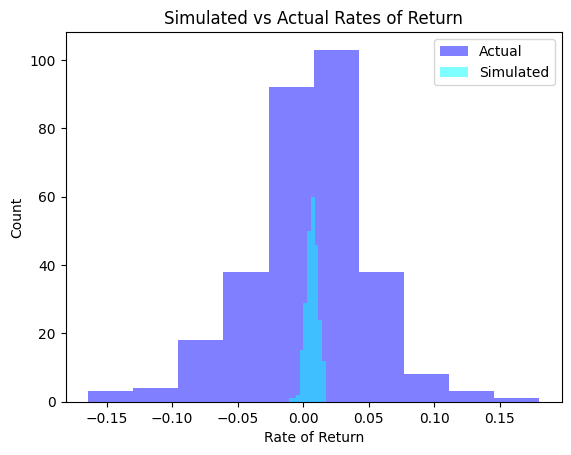

In [149]:
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

# Lets take the mean and sd of th whole data set for the fund
sd = fund_data["Rate"].std()
mean = fund_data["Rate"].mean()

print(f"Mean monthly rate of the whole fund history: {fund_data['Rate'].mean():.4f}")
print(f"Median monthly rate of the whole fund history: {fund_data['Rate'].median():.4f}")

mean = .006473
# Compute 100 times and take the median
sim_data = np.random.normal(mean, sd, (12*TIME_HORIZON,100))
sim_avgs = np.mean(sim_data, axis=1)

fund_data_slice = pd.DataFrame(columns=["Date", "Dividend"])
this_date = datetime.datetime.now()
# Add in the dividend every December
for i in range(12 * TIME_HORIZON):
    this_date += relativedelta(months=1)
    if this_date.month == 12:
        dividend_rate = STANDARD_DIVIDEND_RATE
    else:
        dividend_rate = 0
    new_row_df = pd.DataFrame([{"Date":this_date, "Dividend":dividend_rate}])
    fund_data_slice = pd.concat((fund_data_slice, new_row_df),  axis=0, ignore_index=True)

fund_data_slice["Simulated_Rate"] = list(sim_avgs)

# Lets also visualize the results
plt.hist(fund_data["Rate"], lw=2, fc=(0, 0, 1, 0.5))
plt.hist(fund_data_slice["Simulated_Rate"], lw=2, fc=(0, 1, 1, 0.5))

plt.title(f"Simulated vs Actual Rates of Return")
plt.xlabel("Rate of Return")
plt.ylabel("Count")
plt.legend(["Actual", "Simulated"])
plt.show()

Now we have set of simulated fund data to use for our investment predictions, we can compare the **Pay Off Focused** vs **Investment Focused** strategies.

We will do this several times with different proportions of the monthly contribution going towards the mortgage or investment account.

In [150]:

results_dict = {}
for ratio in np.arange(0, 1+INVEST_PORTION_INCREMENT, INVEST_PORTION_INCREMENT):
    columns = [
        "Date",
        "Invesment_Rate",
        "Investment_Dividend_Rate",
        "Out_of_Pocket",
        "Contribution_Investment",
        "Payment_Mortgage",
        "Equity",
        "Loan_Balance",
        "Investment_Principal",
        "Investment_Amt",
        "Net_Value",
    ]
    results_df = pd.DataFrame(columns=columns)

    inv = INVESTMENT_STARTING
    loan = LOAN_BALANCE
    out_of_pocket = INVESTMENT_STARTING
    this_date = datetime.datetime.now()
    inv_principal = INVESTMENT_STARTING
    home_value = HOME_PRICE

    for row in fund_data_slice.itertuples():

        # Set up initial amounts for each evaluation
        inv_cont = ratio * MONTHLY_CONTRIBUTION
        mort_pay = min_monthly + (1 - ratio) * MONTHLY_CONTRIBUTION

        # Calculate the out of pocket, same for both strategies
        out_of_pocket += min_monthly + MONTHLY_CONTRIBUTION

        this_date = this_date + relativedelta(months=1)

        # Calculate the mortgage first to see if any is left over
        if loan > 0:
            loan = loan_func(
                mon_pay=min_monthly,
                prin_pay=mort_pay - min_monthly,
                rate=LOAN_APR,
                balance=loan,
                )
            # If the loan is paid off
            # - attribute the remaining balance of the payment to the investment
            # - set the loan balance to 0
            if loan < 0:
                inv_cont += -loan
                loan = 0
        else:
            inv_cont += mort_pay

        cash_equity = LOAN_BALANCE - loan + STARTING_EQUITY # This is in abolute dollars and does not account for the value of the house growing
        home_value = home_value * (1 + HOME_VALUE_MPR) # Home value growth
        equity = home_value * ((LOAN_AMT - loan) / LOAN_AMT) # This is the equity amount including home value growth

        # Calculate the return on investment
        inv = calc_invest_balance(
            invest_balance=inv,
            exp_ratio=INVESTMENT_ER,
            return_rate=row.Simulated_Rate,
            dividend_rate=row.Dividend,
            monthly_contribution=inv_cont,
        )

        # Increment the amount put towards the investment principal
        inv_principal += inv_cont

        new_row_dict = {
            "Date":this_date,
            "Invesment_Rate":row.Simulated_Rate,
            "Investment_Dividend_Rate":row.Dividend,
            "Out_of_Pocket":out_of_pocket,
            "Contribution_Investment":inv_cont,
            "Home_Value": home_value,
            "Payment_Mortgage":mort_pay,
            "Equity": equity,
            "Cash_Equity":cash_equity,
            "Loan_Balance":loan,
            "Investment_Principal":inv_principal,
            "Investment_Gains":inv - inv_principal,
            "Investment_Amt":inv,
            "Cash_Investment_Value":(inv - inv_principal) * (1 - TAX_RATE) + inv_principal,
            "Net_Value":inv + equity - out_of_pocket,
        }
        new_row_df = pd.DataFrame([new_row_dict])
        results_df = pd.concat([results_df, new_row_df], axis=0, ignore_index=True)
        inv_perc = f"{ratio * 100:.0f}%"
        loan_perc = f"{(1 - ratio) * 100:.0f}%"
        results_dict[f"{inv_perc}_to_Investment_{loan_perc}_to_Mortgage"] = results_df
results_dict[f"{inv_perc}_to_Investment_{loan_perc}_to_Mortgage"].head()

,Date,Invesment_Rate,Investment_Dividend_Rate,Out_of_Pocket,Contribution_Investment,Payment_Mortgage,Equity,Loan_Balance,Investment_Principal,Investment_Amt,Net_Value,Home_Value,Cash_Equity,Investment_Gains,Cash_Investment_Value
0,2023-02-22 17:14:39.358339,0.006358,0,52267.646135,700.0,1567.646135,64550.435353,336821.846717,50700.0,51002.903604,63285.692822,525399.267472,188141.943283,302.903604,50930.812546
1,2023-03-22 17:14:39.358339,0.002141,0,54535.292270,700.0,1567.646135,65693.669855,336026.083981,51400.0,51796.824349,62955.201934,525835.106190,188937.706019,396.824349,51702.380154
2,2023-04-22 17:14:39.358339,0.004643,0,56802.938405,700.0,1567.646135,66841.255923,335228.497621,52100.0,52721.754710,62760.072227,526271.306453,189735.292379,621.754710,52573.777089
3,2023-05-22 17:14:39.358339,0.004027,0,59070.584540,700.0,1567.646135,67993.207795,334429.083460,52800.0,53618.264976,62540.888231,526707.868560,190534.706540,818.264976,53423.517912
4,2023-06-22 17:14:39.358339,0.011193,0,61338.230675,700.0,1567.646135,69149.539754,333627.837308,53500.0,54902.317326,62713.626405,527144.792812,191335.952692,1402.317326,54568.565802


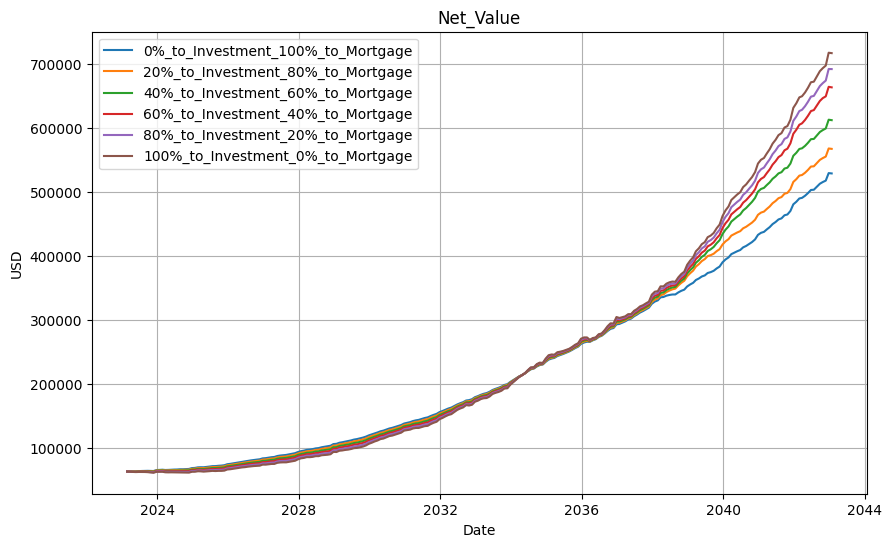

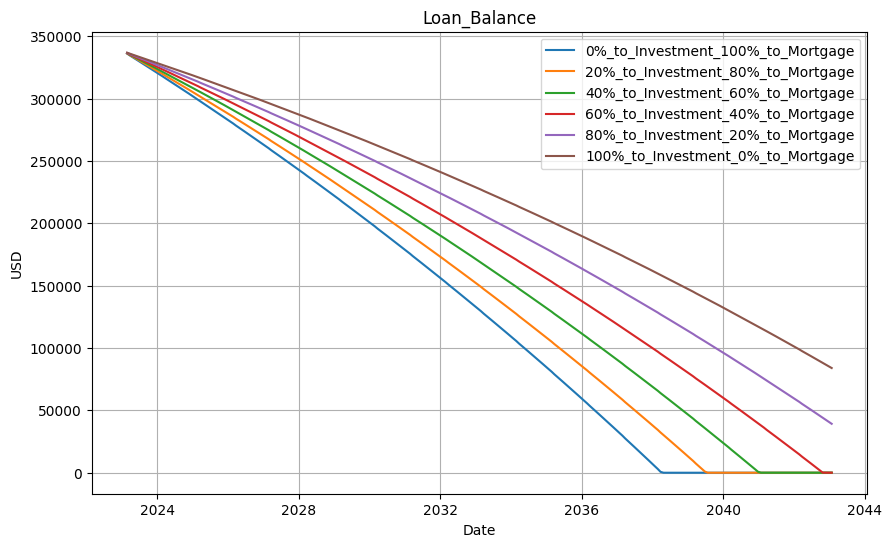

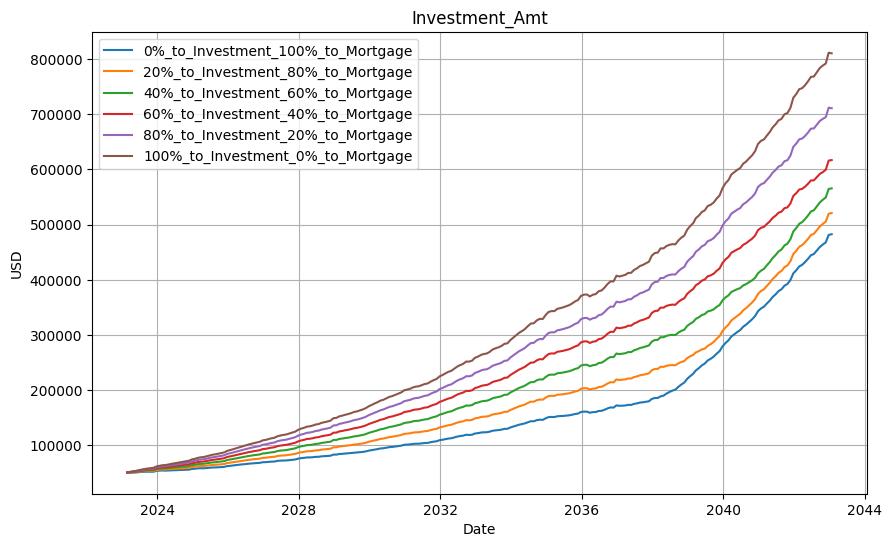

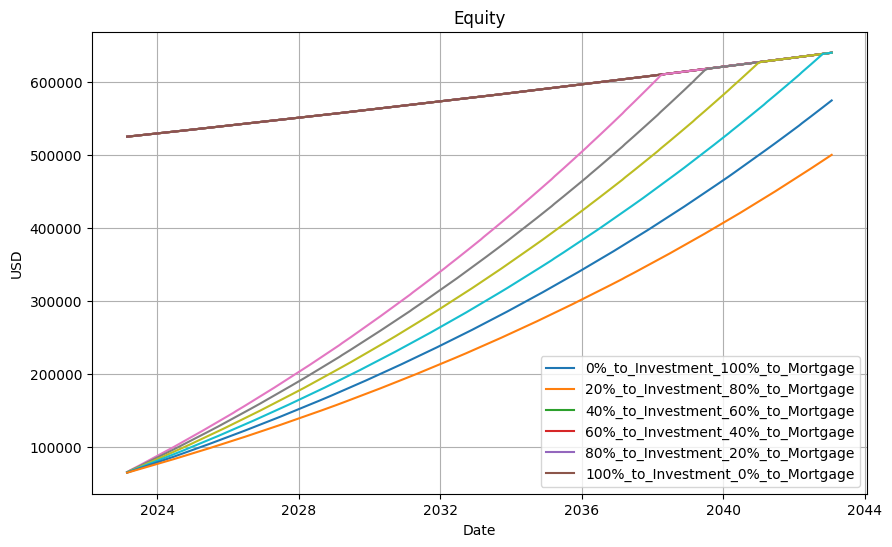

In [151]:
# Plot the results
graph_groups = [
    (
        "Net_Value",
    ),
    (
        "Loan_Balance",
    ),
    (
        "Investment_Amt",
    ),
    (
        "Home_Value",
        "Equity",
    ),
]
for group in graph_groups:
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(6)
    for col in group:
        for key in results_dict.keys():
            plt.plot(results_dict[key]["Date"], results_dict[key][col])
        
    plt.grid(True)
    plt.legend(results_dict.keys())
    plt.title(col)
    plt.xlabel("Date")
    plt.ylabel("USD")
    plt.show()

Let's look at what would happen if we leveraged the investment balance to pay off the loan once the investment balance is equal to the outstanding loan amount.

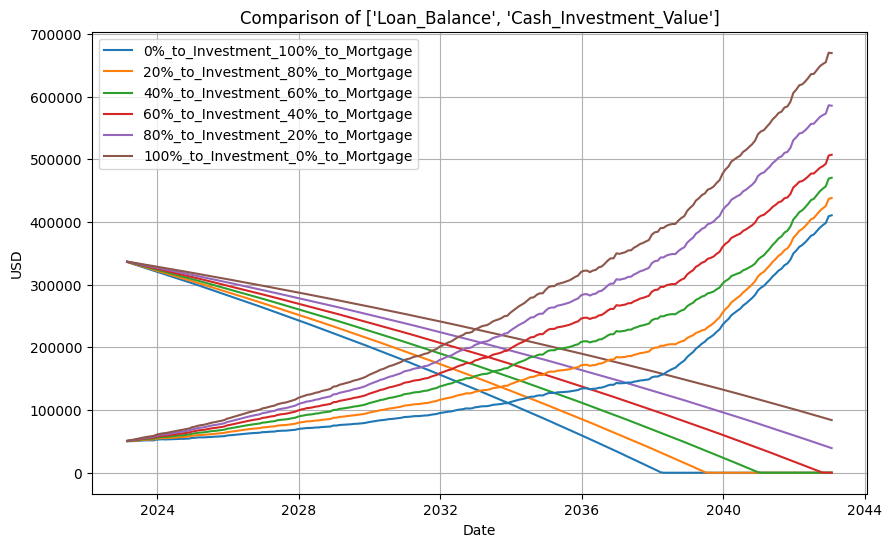

The 0%_to_Investment_100%_to_Mortgage strategy has generated enough in the investment to pay off the loan on 2033-12-22
The 20%_to_Investment_80%_to_Mortgage strategy has generated enough in the investment to pay off the loan on 2033-09-22
The 40%_to_Investment_60%_to_Mortgage strategy has generated enough in the investment to pay off the loan on 2033-07-22
The 60%_to_Investment_40%_to_Mortgage strategy has generated enough in the investment to pay off the loan on 2033-05-22
The 80%_to_Investment_20%_to_Mortgage strategy has generated enough in the investment to pay off the loan on 2033-03-22
The 100%_to_Investment_0%_to_Mortgage strategy has generated enough in the investment to pay off the loan on 2033-01-22


In [152]:
import matplotlib.colors as mcolors

compare_list = [
    "Loan_Balance",
    "Cash_Investment_Value",
]
color_keys = list(mcolors.TABLEAU_COLORS.keys())
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)
for col in compare_list:
    for i, key in enumerate(results_dict.keys()):
        plt.plot(results_dict[key]["Date"], results_dict[key][col], color=mcolors.TABLEAU_COLORS[color_keys[i]])
        
plt.grid(True)
plt.legend(results_dict.keys())
plt.title(f"Comparison of {compare_list}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.show()
        

# Find when the loan balance is equal to the investment balance * 1.2 to account for taxes
for key in results_dict.keys():
    for row in results_dict[key].itertuples():
        if row.Cash_Investment_Value > row.Loan_Balance:
            print(f"The {key} strategy has generated enough in the investment to pay off the loan on {row.Date:%Y-%m-%d}")
            break
        